BloomTech Data Science

*Unit 2, Sprint 1, Module 4*

---

In [2]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Linear-Models/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

# Module Project: Logistic Regression

Do you like burritos? 🌯 You're in luck then, because in this project you'll create a model to predict whether a burrito is `'Great'`.

The dataset for this assignment comes from [Scott Cole](https://srcole.github.io/100burritos/), a San Diego-based data scientist and burrito enthusiast. 

## Directions

The tasks for this project are the following:

- **Task 1:** Import `csv` file using `wrangle` function.
- **Task 2:** Conduct exploratory data analysis (EDA), and modify `wrangle` function .
- **Task 3:** Split data into feature matrix `X` and target vector `y`.
- **Task 4:** Split feature matrix `X` and target vector `y` into training and test sets.
- **Task 5:** Establish the baseline accuracy score for your dataset.
- **Task 6:** Build `model_logr` using a pipeline that includes three transfomers and `LogisticRegression` predictor. Train model on `X_train` and `X_test`.
- **Task 7:** Calculate the training and test accuracy score for your model.
- **Task 8:** Create a horizontal bar chart showing the 10 most influencial features for your  model. 
- **Task 9:** Demonstrate and explain the differences between `model_lr.predict()` and `model_lr.predict_proba()`.

**Note** 

You should limit yourself to the following libraries:

- `category_encoders`
- `matplotlib`
- `pandas`
- `sklearn`

In [82]:
import pandas as pd
import numpy as np

# I. Wrangle Data

In [230]:
def wrangle(filepath):
    # Import w/ DateTimeIndex
    df = pd.read_csv(filepath, parse_dates=['Date'],
                     index_col='Date')
    
    # Format Column Named
    df.columns = df.columns.str.upper().str.replace(' ', '_')

    # Drop unrated burritos
    df = df.dropna(subset=['OVERALL'])
    
    # Derive binary classification target:
    # We define a 'Great' burrito as having an
    # overall rating of 4 or higher, on a 5 point scale
    df['GREAT'] = (df['OVERALL'] >= 4).astype('uint8')
    
    # Drop high cardinality categoricals
    df = df.drop(columns=['NOTES', 'LOCATION', 'ADDRESS', 'URL', 'NEIGHBORHOOD'])
    
    # Drop columns to prevent "leakage"
    df = df.drop(columns=['REC', 'OVERALL'])

    #Binary Encoding
    binary_encoding_needed = (set(df.nunique()[df.nunique().isin(range(0,6))].index) 
                              & set(df.dtypes[ df.dtypes=='object' ].index))
    for col in binary_encoding_needed:
      df.loc[ (df.loc[:][col].str.upper() == 'X') | 
             (df.loc[:][col].str.upper() == 'YES'), col] = 1
      df.loc[ (df.loc[:][col].isnull()) |
             (df.loc[:][col].astype('string').str.upper() == 'NO'), col] = 0
      df[col] = df[col].astype('uint8')

    #Burrito Formatting
    n_most_freq_burrito_types = 4
    df['BURRITO'] = ( 'BURRITO_' + df['BURRITO'].str.strip()
                      .str.upper().str.replace(' ', '_') )
    burrito_types = list(df['BURRITO'].value_counts().head(10).index)
    df.loc[ ~(df['BURRITO'].isin(burrito_types)), 'BURRITO' ] = 'OTHER'
    df = ( df.join(pd.get_dummies(df['BURRITO'])).
           drop(columns=['OTHER', 'BURRITO']) )

    #Drop Columns
    threshhold = 10 #Min # Of Uniques For High Cardinality
    drop = [col for col in df if ( df[col].nunique()<=1 
            or (df[col].dtype=='object' and df[col].nunique()>threshhold) )]
    df = df.drop(columns=drop)


    return df

filepath = DATA_PATH + 'burritos/burritos.csv'

df = wrangle(filepath)

**Task 1:** Use the above `wrangle` function to import the `burritos.csv` file into a DataFrame named `df`.

**Task 2:** Change the `wrangle` function so that the beef columns are properly encoded as `0` and `1`s. Be sure your code handles upper- and lowercase `X`s, and `NaN`s.

In [234]:
# Conduct your exploratory data analysis here
# And modify the `wrangle` function above.

def show_col(df):
  for i, col in enumerate(list(df.columns)):
    output = ('('+str(i+1)+')'+col+': '
              +str(df[col].nunique())+' unique '+str(df[col].dtype)+'s')
    if (i+1)%3 != 0:
      print(output, end='   ')
    else:
      print(output)

show_col(df); print()

print("Data Types:", list(df.dtypes.unique()))

(1)YELP: 6 unique float64s   (2)GOOGLE: 18 unique float64s   (3)CHIPS: 2 unique uint8s
(4)COST: 98 unique float64s   (5)HUNGER: 25 unique float64s   (6)MASS_(G): 18 unique float64s
(7)DENSITY_(G/ML): 21 unique float64s   (8)LENGTH: 29 unique float64s   (9)CIRCUM: 30 unique float64s
(10)VOLUME: 64 unique float64s   (11)TORTILLA: 18 unique float64s   (12)TEMP: 18 unique float64s
(13)MEAT: 23 unique float64s   (14)FILLINGS: 22 unique float64s   (15)MEAT:FILLING: 25 unique float64s
(16)UNIFORMITY: 28 unique float64s   (17)SALSA: 27 unique float64s   (18)SYNERGY: 27 unique float64s
(19)WRAP: 23 unique float64s   (20)UNRELIABLE: 2 unique uint8s   (21)NONSD: 2 unique uint8s
(22)BEEF: 2 unique uint8s   (23)PICO: 2 unique uint8s   (24)GUAC: 2 unique uint8s
(25)CHEESE: 2 unique uint8s   (26)FRIES: 2 unique uint8s   (27)SOUR_CREAM: 2 unique uint8s
(28)PORK: 2 unique uint8s   (29)CHICKEN: 2 unique uint8s   (30)SHRIMP: 2 unique uint8s
(31)FISH: 2 unique uint8s   (32)RICE: 2 unique uint8s   (33)BEAN

If you explore the `'Burrito'` column of `df`, you'll notice that it's a high-cardinality categorical feature. You'll also notice that there's a lot of overlap between the categories. 

**Stretch Goal:** Change the `wrangle` function above so that it engineers four new features: `'california'`, `'asada'`, `'surf'`, and `'carnitas'`. Each row should have a `1` or `0` based on the text information in the `'Burrito'` column. For example, here's how the first 5 rows of the dataset would look.

| **Burrito** | **california** | **asada** | **surf** | **carnitas** |
| :---------- | :------------: | :-------: | :------: | :----------: |
| California  |       1        |     0     |    0     |      0       |
| California  |       1        |     0     |    0     |      0       |
|  Carnitas   |       0        |     0     |    0     |      1       |
| Carne asada |       0        |     1     |    0     |      0       |
| California  |       1        |     0     |    0     |      0       |

**Note:** Be sure to also drop the `'Burrito'` once you've engineered your new features.

# II. Split Data

**Task 3:** Split your dataset into the feature matrix `X` and the target vector `y`. You want to predict `'Great'`.

In [238]:
target = 'GREAT'
X = df.drop(columns=target)
y = df[target]

**Task 4:** Split `X` and `y` into a training set (`X_train`, `y_train`) and a test set (`X_test`, `y_test`).

- Your training set should include data from 2016 through 2017. 
- Your test set should include data from 2018 and later.

In [239]:
df.index

DatetimeIndex(['2011-05-16', '2015-04-20', '2016-01-18', '2016-01-24',
               '2016-01-24', '2016-01-24', '2016-01-24', '2016-01-24',
               '2016-01-24', '2016-01-24',
               ...
               '2019-08-27', '2019-08-27', '2019-08-27', '2019-08-27',
               '2019-08-27', '2019-08-27', '2019-08-27', '2019-08-27',
               '2019-08-27', '2026-04-25'],
              dtype='datetime64[ns]', name='Date', length=2119, freq=None)

In [242]:
mask = (df.index.year == 2016) | (df.index.year == 2017)
X_train, y_train = X[mask], y[mask]
X_test, y_test = X[~mask], y[~mask]

# III. Establish Baseline

**Task 5:** Since this is a **classification** problem, you should establish a baseline accuracy score. Figure out what is the majority class in `y_train` and what percentage of your training observations it represents. 

In [243]:
pd.DataFrame(y_train.value_counts(normalize=True)*100)

,GREAT
0,61.972547
1,38.027453


In [244]:
baseline_acc = y_train.value_counts(normalize=True).max()
print('Baseline Accuracy Score:', baseline_acc)

Baseline Accuracy Score: 0.619725470259278


# IV. Build Model

**Task 6:** Build a `Pipeline` named `model_logr`, and fit it to your training data. Your pipeline should include:

- a `OneHotEncoder` transformer for categorical features, 
- a `SimpleImputer` transformer to deal with missing values, 
- a [`StandarScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) transfomer (which often improves performance in a logistic regression model), and 
- a `LogisticRegression` predictor.

In [245]:
from sklearn.pipeline import make_pipeline
from category_encoders import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

model_logr = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    SimpleImputer(strategy='mean'),
    StandardScaler(),
    LogisticRegression()
)
model_logr.fit(X_train, y_train)

Pipeline(steps=[('onehotencoder', OneHotEncoder(cols=[], use_cat_names=True)),
                ('simpleimputer', SimpleImputer()),
                ('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression())])

# IV. Check Metrics

**Task 7:** Calculate the training and test accuracy score for `model_lr`.

In [246]:
training_acc = model_logr.score(X_train, y_train)
test_acc = model_logr.score(X_test, y_test)

print('Training Accuracy:', training_acc)
print('Test Accuracy:', test_acc)

Training Accuracy: 0.9354346720894764
Test Accuracy: 0.7960526315789473


# V. Communicate Results

**Task 8:** Create a horizontal barchart that plots the 10 most important coefficients for `model_lr`, sorted by absolute value.

**Note:** Since you created your model using a `Pipeline`, you'll need to use the [`named_steps`](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) attribute to access the coefficients in your `LogisticRegression` predictor. Be sure to look at the shape of the coefficients array before you combine it with the feature names.

In [269]:
coefficients = model_logr.named_steps['logisticregression'].coef_[0]
features = model_logr.named_steps['onehotencoder'].get_feature_names()
#Vertical Bars w/ Sign Displayed
# important_features = pd.Series(coefficients, index=features).sort_values(key=abs, ascending=False)
# important_features.plot(kind='bar', figsize=(20,10));

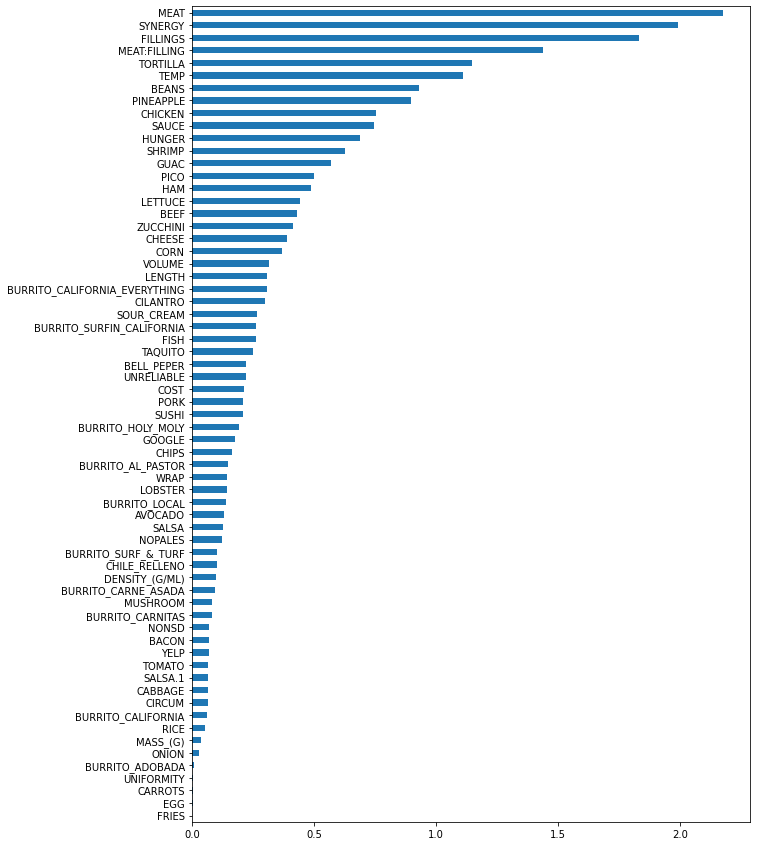

In [268]:
important_features = pd.Series(abs(coefficients), index=features).sort_values()
important_features.plot(kind='barh', figsize=(10,15));

There is more than one way to generate predictions with `model_lr`. For instance, you can use [`predict`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html?highlight=logisticregression) or [`predict_proba`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html?highlight=logisticregression#sklearn.linear_model.LogisticRegression.predict_proba).

**Task 9:** Generate predictions for `X_test` using both `predict` and `predict_proba`. Then below, write a summary of the differences in the output for these two methods. You should answer the following questions:

- What data type do `predict` and `predict_proba` output?
- What are the shapes of their different output?
- What numerical values are in the output?
- What do those numerical values represent?

In [289]:
# Write code here to explore the differences between `predict` and `predict_proba`.

predictions = model_logr.predict(X_test); print("Predicted Greatness:")
print(predictions); print()

predicted_proba = model_logr.predict_proba(X_test)[:,1]*100
print("Predicted Probability of Greatness:");print(predicted_proba.round(1)); print()

more_predictions = (predicted_proba > 50).astype('int')
print('Predicted Greatness Using Predicted Probability of Greatness:')
print(more_predictions); print()

print("Difference:", (predictions - more_predictions).sum())

Predicted Greatness:
[0 1 1 1 1 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 0 0 0 0 0
 0 0 0 0 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0
 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1]

Predicted Probability of Greatness:
[  0.  100.   99.9  86.8 100.  100.    0.1   0.4  13.3  99.4  99.4  99.4
 100.  100.  100.   68.1  68.1  68.1  98.7  98.7  90.6  90.6   1.    1.
  36.   36.   82.7  82.7  98.7  98.7  81.2  64.6  48.9  28.7   0.    0.
   0.    0.    0.1   0.4   0.4  99.3  99.3  30.7  30.7  28.5  28.5  30.7
  82.3  82.3  80.7  80.7  82.3  95.6  95.6  95.1  95.1  95.6  16.6  16.6
  15.1  15.1  16.6   9.1   9.1   8.2   8.2   9.1 100.   92.1  99.9  99.9
 100.   99.8 100.   99.9  99.8  99.9  99.9   2.1   3.3   7.9   1.8   7.9
   2.1   1.8   2.1   2.1  87.8  91.9  96.6  85.9  96.6  87.8  85.9  87.8
  87.8  88.2  92.1  96.7  86.3  96.7  88.2  86.3  

**Give your written answer here:**

```
predict outputs an integer array corresponding to the classification of each test observation. 

predict_proba outputs an n x 2 array of floats corresponding to the probability
that each observation can be classified under each category.

```